# Notebook with empirical analyses on the influence of confounds in MVPA
In this notebook, we evaluate different strategies to deal with confounds in MVPA on empirical data (see [this notebook](LINK) for analyses of simulated data). Here, we try to predict gender (male/female) from structural MRI data (VBM and TBSS data) in face of the confound 'brain size'. We chose 'brain size' as a confound, because one could argue that overall brain size is not an interesting predictive feature in MVPA analyses, as people usually try to investigate more *local* gender differences in brain structure. Note that we only focus on this use case because the data was available; we do not wish to draw any conclusions from the results of this study apart from the statistical issues.

### First some imports
Make sure you have the latest version of scikit-learn (0.19), pandas (>=0.20.0), and our own skbold package (0.3.3, or preferably from the [master branch on github](https://github.com/lukassnoek/skbold)) installed.

In [1]:
import os.path as op
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.externals import joblib as jl
import seaborn as sns
import scipy.stats as stats
from copy import deepcopy
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style='whitegrid', context='poster')
rc = {"font.size":25, "axes.titlesize":25, "axes.labelsize":25, 
      "legend.fontsize":15, "xtick.labelsize": 15,
      "ytick.labelsize": 15, "text.usetex": True}

### Loading in the data
Below we load in the behavioral data (`PIOP1_behav_2017_with_brainsize.tsv`), which includes our factor-to-decode, "Gender", and our confound-of-interest ("brain_size"). The feature 'brain size' was calculated as the total amount of non-zero voxels of each subject's gray-matter segmented T1-weighted structural scan (as segmented by [FSL FAST](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/FAST); FSL v5.0).

The voxel patterns are contained in the `Mvp` objects - a data-structure defined in the [skbold](skbold.readthedocs.io) package - in the attribute `X` (a $N$ [subjects] $\times\ K$ [voxels] numpy array). Two sets of voxel patterns are loaded: one with VBM data (processed with the standard [FSL-VBM pipeline](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/FSLVBM)) and one with skeletonized FA-data (processed with the standard [FSL-TBSS pipeline](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/TBSS) for a total of 217 subjects.

In [3]:
base_dir = '/media/lukas/goliath/MVCA/data/mvp'
behav_file = op.join(base_dir, 'PIOP1_behav_2017_MVCA_with_brainsize.tsv')

# Load in VBM-mvp ...
mvp_vbm = jl.load(op.join(base_dir, 'mvp_vbm.jl'))

# ... and add "Gender" as "y" attribute
mvp_vbm.add_y(behav_file, col_name='Gender', index_col=0, nan_strategy='remove')
mvp_vbm.y = 1 - (mvp_vbm.y - 1)  # recode from [2, 1] to [0, 1] 
print("Shape of VBM voxel patterns: %s" % (mvp_vbm.X.shape,))

# Same for TBSS
mvp_tbss = jl.load(op.join(base_dir, 'mvp_tbss.jl'))
mvp_tbss.add_y(behav_file, col_name='Gender', index_col=0, nan_strategy='remove')
mvp_tbss.y -= 1
print("Shape of TBSS voxel patterns: %s" % (mvp_tbss.X.shape,))

Shape of VBM voxel patterns: (217, 412473)
Shape of TBSS voxel patterns: (217, 128340)


Note that the TBSS Mvp contains way fewer voxels due to the fact that `skbold` already removed all 0 voxels (i.e. voxels outside the TBSS skeleton). 

Now, we load in the confound - brain size - from the same file with "behavioral" data:

In [4]:
df = pd.read_csv(behav_file, index_col=0, sep='\t')
confound_vbm = df.loc[mvp_vbm.common_subjects]['brain_size']
confound_tbss = df.loc[mvp_tbss.common_subjects]['brain_size']

### Setting analysis parameters
For the first couple of confound strategies (here we call them "scenarios"), we set some default parameters for our MVPA pipelines.

In [5]:
n_folds = 10  # used in stratified K-fold
n_jobs = 8    # for parallel execution of pipelines through joblib

# Make a dict of both Mvps
mvp = dict(vbm=mvp_vbm, tbss=mvp_tbss)

# ... same for confounds (although they're the same here)
confound = dict(vbm=confound_vbm[:, np.newaxis],
                tbss=confound_tbss[:, np.newaxis])

# We're going to evaluate the scenarios for different amounts of voxels
num_vox = np.round(np.logspace(2, 5, num=8)).astype(int)

# We'll use F1-score as an evaluation metric because our classes
# are be slightly imbalanced (i.e. more female than male subjects)
metric = 'f1_macro'

# The default pipeline we'll use: 
# - univariate feature selection (f-test)
# - zero-mean / unit std scaling
# - linear SVM
pipeline = Pipeline([('ufs', SelectKBest(f_classif, k=None)),
                     ('scaler', StandardScaler()),
                     ('clf', SVC(kernel='linear'))])

## Sanity check: does brain-size predict gender?
Before anything else, we should evaluate whether brain-size is truly a confound. We do this in two ways. First, we can simply calculate the correlation between brain size and gender (or, more aptly, the 'pointbiserial correlation').

In [7]:
# Note that we use the VBM mvp object here, but given that the confound and gender-factor is 
# exactly the same for both VBM/TBSS (i.e., they contain the same subjects), we just pick VBM
corr, pval = stats.pearsonr(confound['vbm'].squeeze(), mvp['vbm'].y)
print("Correlation (p-value) between brain-size and gender: %.3f (%.4f)" % (corr, pval))

Correlation (p-value) between brain-size and gender: 0.645 (0.0000)


Next to calculating the simple correlation, we can also evualate dependence by using the [Same Analysis Approach](https://arxiv.org/abs/1703.06670) (SAA) suggested by Görgen and colleagues. SAA suggests to simply use your potential confound as a single feature in a classification analysis. Here, we can use brain size as a single predictor in a model trying to predict gender.

Let's find out:

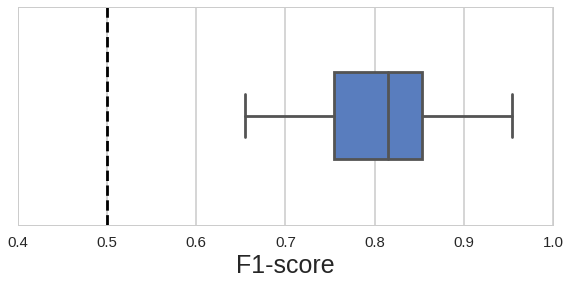

In [8]:
# We leave out univariate feature selection, but include the scaler
pipeline_check = Pipeline([('scaler', StandardScaler()),
                           ('clf', SVC(kernel='linear'))])

# Confound and y are the same for VBM & TBSS
this_mvp, this_confound = mvp['vbm'], confound['vbm']
scores = cross_val_score(pipeline_check, this_confound, this_mvp.y,
                         cv=n_folds, scoring=metric, n_jobs=n_jobs)
results_check = {'scores': scores}
df_check = pd.DataFrame(results_check)

with sns.plotting_context(rc=rc):
    fig = plt.gcf()
    fig.set_size_inches((9.6, 4.01))
    g = sns.boxplot(df_check['scores'], width=0.4, orient='h', palette="muted")
    g.set(xlim=(.4, 1), xlabel='F1-score')
    plt.axvline(x=0.5, c='black', ls='dashed')
    plt.show()

Conclusion: yes, very accurately so (F1 > 0.8)! Thus, we can conclude that 'brain size' is a potential confound in our analyses!

## Distribution of correlation between voxels and gender & voxels and brain-size
Now, it might be informative to check the dependence between our voxels (in both the VBM and TBSS) and gender, just to get an intuition on how the distribution of correlations looks like. This kind of amounts to a mass-univariate analysis. But, importantly, we also quickly take a look at how this distribution changes when we account for brain-size (that is, we regress brain-size out of each feature/voxel). Later in this notebook, we elaborate more on this method!

First, we'll regress out brain-size from each voxel (using simple OLS). In other words, the new data will contain the residuals from the model: $voxel = \beta_{0} + \beta_{1} brainsize + \epsilon$

In [9]:
mvp_no_brainsize = dict()
        
for modality in ['vbm', 'tbss']:
    design = np.hstack((np.ones((mvp[modality].X.shape[0], 1)),
                        confound[modality]))

    tmp = deepcopy(mvp[modality])
    
    for vox in tqdm_notebook(range(mvp[modality].X.shape[1]), desc='regression (%s)' % modality):
        beta = np.linalg.lstsq(design, mvp[modality].X[:, vox])[0]
        tmp.X[:, vox] -= beta.dot(design.T) 
    mvp_no_brainsize[modality] = tmp

Now, let's check the distribution of correlations between the voxels and gender, both before and after regressing out the confound.

In [16]:
corrs_Xy = dict(corrs=[], type=[], modality=[])

for modality in ['vbm', 'tbss']:

    for vox in tqdm_notebook(range(mvp[modality].X.shape[1]), desc='Analyzing %s' % modality):
        corrs_Xy['corrs'].append(stats.pearsonr(mvp[modality].X[:, vox], mvp[modality].y)[0])
        corrs_Xy['type'].append('original')
        corrs_Xy['modality'].append(modality.upper())
        corrs_Xy['corrs'].append(stats.pearsonr(mvp_no_brainsize[modality].X[:, vox], mvp[modality].y)[0])
        corrs_Xy['type'].append('corrected')
        corrs_Xy['modality'].append(modality.upper())

And let's plot it!

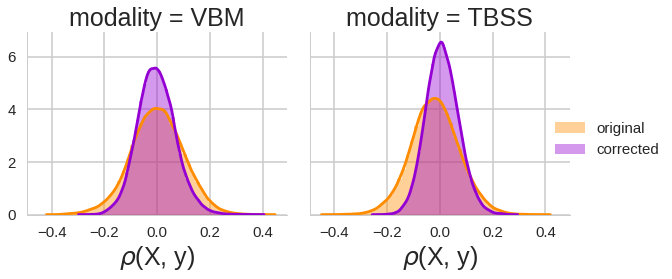

In [26]:
corrs_Xy_df = pd.DataFrame(corrs_Xy)

with sns.plotting_context(rc=rc):
    colorpalette = dict(original="darkorange", corrected="darkviolet")
    g = sns.FacetGrid(corrs_Xy_df, col='modality', hue='type', legend_out=True, size=5, palette=colorpalette)
    g = g.map(sns.distplot, "corrs")
    g.add_legend(title='')
    g.set(xlabel=r'$\rho$(X, y)')
    fig = plt.gcf()
    fig.set_size_inches((9.6, 4.01))
    plt.show()

And let's calculate some descriptive statistics:

In [30]:
corrs_Xy_df.groupby('modality').corrs.describe()

,count,mean,std,min,25%,50%,75%,max
modality,,,,,,,,
TBSS,256680.0,-0.004726,0.079582,-0.422222,-0.054353,-0.003623,0.046260,0.391171
VBM,824946.0,-0.000642,0.086781,-0.396356,-0.056680,-0.002260,0.054363,0.424509


What we see in the plot above makes sense: after removing variance in X associated with brain-size, the correlation distribution (between voxels and gender) becomes more narrow (but, as explained in the [notebook with simulations](simulation_confound_strategies.ipynb), this is *too narrow*, which we'll discuss later)!

Moreover, let's check out the dependence between the voxels and brainsize:

In [35]:
corrs_Xc = dict(corrs=[], modality=[])

for modality in ['vbm', 'tbss']:
    
    for vox in tqdm_notebook(range(mvp[modality].X.shape[1]), desc='analyzing %s' % modality):
        corrs_Xc['corrs'].append(stats.pearsonr(mvp[modality].X[:, vox], confound[modality].squeeze())[0])
        corrs_Xc['modality'].append(modality.upper())

Let's check out some descriptive statistics:

In [36]:
corrs_Xc_df = pd.DataFrame(corrs_Xc)
corrs_Xc_df.groupby('modality').corrs.describe()

,count,mean,std,min,25%,50%,75%,max
modality,,,,,,,,
TBSS,128340.0,0.042163,0.095494,-0.332083,-0.022008,0.041546,0.105466,0.449613
VBM,412473.0,0.004289,0.120971,-0.469915,-0.070307,0.008343,0.083418,0.420398


And plot it:

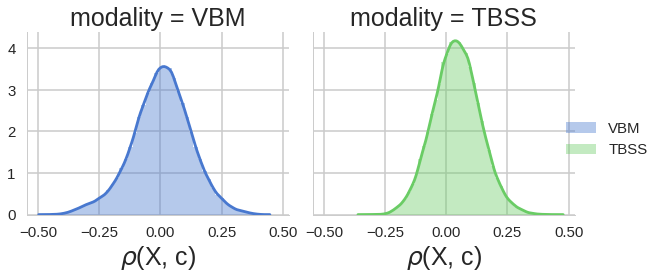

In [39]:
with sns.plotting_context(rc=rc):
    g = sns.FacetGrid(corrs_Xc_df, col='modality', hue='modality', legend_out=True, size=5, palette="muted")
    g = g.map(sns.distplot, "corrs")
    g.add_legend(title='')
    g.set(xlabel=r'$\rho$(X, c)')
    fig = plt.gcf()
    fig.set_size_inches((9.6, 4.01))
    plt.show()

We see that brain-size is quite correlated with our brain data! In the next sections, we'll test out different methods to deal with these confounding influences in multivoxel pattern analyses. First, we'll check how our proposed method - confound regression - does.

## Scenario 1: no confound regression
Now, for a baseline analysis, let's predict gender based on TBSS and VBM data for different amounts of voxels included in the analyses (as selected by `f_classif`):

In [40]:
results_sce1 = dict(n_vox=[], score=[], modality=[])

for modality in ['vbm', 'tbss']:
    this_mvp = mvp[modality]
    for i, nV in enumerate(tqdm_notebook(np.append(num_vox, this_mvp.X.shape[1]),
                                         desc='analyzing %s' % modality)):
        
        pipeline.set_params(ufs__k=nV)
        scores = cross_val_score(pipeline, this_mvp.X, this_mvp.y,
                                 cv=n_folds, scoring=metric, n_jobs=1)
        results_sce1['n_vox'].extend([nV] * n_folds)
        results_sce1['score'].extend(scores.tolist())
        results_sce1['modality'].extend([modality] * n_folds)

Let's plot the results (the dashed line is chance level performance):

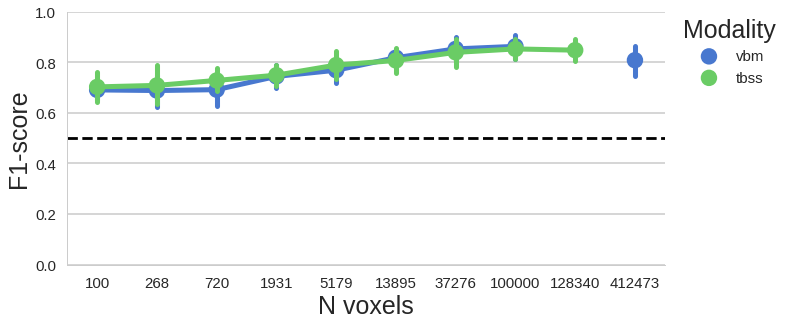

In [43]:
results_sce1_df = pd.DataFrame(results_sce1)
results_sce1_df['method'] = ['none'] * len(results_sce1_df)
with sns.plotting_context(rc=rc):
    fig = plt.gcf()
    fig.set_size_inches((9.6, 4.01))
    g = sns.factorplot(x='n_vox', y='score', hue='modality', data=results_sce1_df, size=5, aspect=2, legend_out=False,
                       palette="muted", legend=False)
    g.set(ylim=(0, 1), ylabel='F1-score', xlabel='N voxels')
    plt.axhline(y=0.5, c='black', ls='dashed')
    plt.legend(title='Modality', bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
    plt.show()

As you can see, performance is far above chance, but it is unclear what drives our results ([which is in general a problem in MVPA](http://www.sciencedirect.com/science/article/pii/S1364661315001692) ...): some 'true signal' or signal confounded by brain size? 

Let's look at some other scenarios which try to deal with the brain-size confound and check to what extent it drives classification performance.

## Scenario 2: confound regression on entire dataset
First, we'll evaluate the strategy that is sometimes adopted: regressing out the confound from the entire data-set (here: `X`) at once (like in [this article](http://www.sciencedirect.com/science/article/pii/S1053811913002887)), like we did when we compared the correlation distributions of the voxels and gender/brain-size between "uncorrected" and "corrected" data. 

In the rest of the notebook, we'll discuss and demonstrate different ways of regressing out a confound from the data (`X`), and to reduce the boilerplate code, we wrote a custom `scikit-learn`-style "transformer" class that does exactly this: take a confound upon initialization and subsequently fits a model using the confound to predict each feature in `X` during `fit(X)`, and subsequently regresses out the confound from each feature in `X` during `transform(X)` (in a scikit-learn style). 

For more info on the exact implementation of the `ConfoundRegressor` object, check the [skbold Github repo](https://github.com/lukassnoek/skbold/blob/master/skbold/preproc/confounds.py).

Assuming that the latest version of `skbold` is installed on the system, let's import the `ConfoundRegressor` class.

In [44]:
from skbold.preproc.confounds import ConfoundRegressor

Earlier we already regressed out brain-size from our data (`X`) and stored it in the dictionary `mvp_no_brainsize`. 
Let's now use this data (instead of the 'uncorrected' data) in a classification analysis:

In [46]:
results_sce2 = dict(n_vox=[], score=[], modality=[])

for modality in ['vbm', 'tbss']:
    
    this_mvp = mvp_no_brainsize[modality]
    
    for i, nV in enumerate(tqdm_notebook(np.append(num_vox, this_mvp.X.shape[1]),
                                                   desc='analyzing %s' % modality)):
        
        pipeline.set_params(ufs__k=nV)
        scores = cross_val_score(pipeline, this_mvp.X, this_mvp.y,
                                 cv=n_folds, scoring=metric, n_jobs=-1)
        results_sce2['n_vox'].extend([nV] * n_folds)
        results_sce2['score'].extend(scores.tolist())
        results_sce2['modality'].extend([modality] * n_folds)

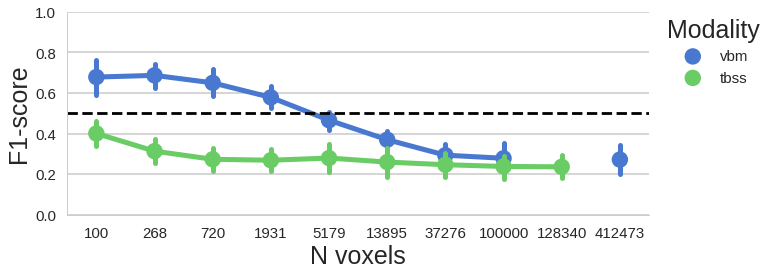

In [47]:
results_sce2_df = pd.DataFrame(results_sce2)
results_sce2_df['method'] = ['regress_no_cv'] * len(results_sce2_df)

with sns.plotting_context(rc=rc):
    ax = sns.factorplot(x='n_vox', y='score', hue='modality', data=results_sce2_df, size=5, aspect=2, legend_out=False,
                        palette='muted', legend=False)
    ax.set(ylim=(0, 1), ylabel='F1-score', xlabel='N voxels')
    plt.axhline(y=0.5, c='black', ls='dashed')
    fig = plt.gcf()
    fig.set_size_inches((9.6, 4.01))
    plt.legend(title='Modality', bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
    plt.show()

**What is happening??** We see that classification performance quickly drops under chance level with an increasing number of voxels in our analyses... As we argue in our paper and show in our simulations (see [this](simulation_confound_strategies.ipynb) notebook), this is due to the fact that we've regressed out our confound on the *entire data-set (X)*, which causes the distribution of correlations between features (`X`) and the target (`y`) to become too narrow (i.e., narrower than expected by chance).

In [69]:
for modality in ['vbm', 'tbss']:
    
    this_mvp = mvp_no_brainsize[modality]
    this_corrs_df = corrs_Xy_df[corrs_Xy_df.modality == modality.upper()]
    for i, nV in enumerate(tqdm_notebook(np.append(num_vox, this_mvp.X.shape[1]),
                                                   desc='analyzing %s' % modality)):
        skb = SelectKBest(f_classif, k=nV)
        skb.fit(this_mvp.X, this_mvp.y)
        these_corrs = this_corrs_df[this_corrs_df.type == 'corrected'].corrs[skb.get_support()]
        
        ys = rpdf(these_corrs.mean(), mvp_no_brainsize[modality].y.size, rs)
        cdf = ECDF(ys)
        inverted_edf = interp1d(np.cumsum(ys[ys > 0]) / np.sum(ys[ys > 0]), rs[ys > 0], bounds_error=False)
        samples = np.random.uniform(0, 1, 100000)
        samples_transformed = inverted_edf(samples)
        print('Analytic: %.3f' % samples_transformed.std())
        print('Observed: %.3f' % these_corrs.std())

/media/lukas/goliath/MVCA/analyses/utils.py:7: RuntimeWarning: divide by zero encountered in log
  lnum = np.log(n-2) + gammaln(n-1) + np.log((1-rho**2)**(.5*(n-1))) + np.log((1-rs**2)**(.5*(n-4)))


Analytic: 0.060
Observed: 0.018
Analytic: 0.061
Observed: 0.025
Analytic: 0.064
Observed: 0.155
Analytic: 0.066
Observed: 0.181
Analytic: 0.067
Observed: 0.199
Analytic: 0.068
Observed: 0.184
Analytic: 0.068
Observed: 0.157
Analytic: 0.068
Observed: 0.125
Analytic: 0.068
Observed: 0.072



Analytic: 0.064
Observed: 0.068
Analytic: 0.065
Observed: 0.093
Analytic: 0.066
Observed: 0.127
Analytic: 0.067
Observed: 0.135
Analytic: 0.068
Observed: 0.135
Analytic: 0.068
Observed: 0.121
Analytic: 0.068
Observed: 0.099
Analytic: 0.068
Observed: 0.070
Analytic: 0.068
Observed: 0.062



The result is that we see an increase in "sign flips" of correlations between features and the target in the train- versus the test-set in a K-fold cross-validation scheme. (This point is related to what Görgen et al. mention in [their paper](https://arxiv.org/abs/1703.06670) about the "Same analysis approach".)

So, naturally, let's check and see what happens when we fit the confound regression on the train-set only and subsequently use those models to regress the confound on the train- *and* test-set. Or in other words, let's cross-validate our confound-regression

In [88]:
for modality in ['vbm', 'tbss']:
    
    this_mvp = mvp_no_brainsize[modality]
    this_corrs_df = corrs_Xy_df[corrs_Xy_df.modality == modality.upper()]
    for i, nV in enumerate(tqdm_notebook(np.append(num_vox, this_mvp.X.shape[1]),
                                                   desc='analyzing %s' % modality)):
        skb = SelectKBest(f_classif, k=nV)
        skb.fit(this_mvp.X, this_mvp.y)
        skf = StratifiedKFold(n_splits=10)
        
        for train_idx, test_idx in skf.split(this_mvp.X, this_mvp.y):
            X_train, y_train = this_mvp.X[train_idx], this_mvp.y[train_idx]
            X_test, y_test = this_mvp.X[test_idx], this_mvp.y[test_idx]
            
            skb.fit(X_train, y_train)
            this_idx = skb.get_support()
            these_train_vox = X_train[:, this_idx]
            these_test_vox = X_test[:, this_idx]
            
            corrs_train = [pearsonr(these_train_vox[:, i], y_train)[0] for i in range(these_train_vox.shape[1])]
            corrs_test = [pearsonr(these_test_vox[:, i], y_test)[0] for i in range(these_test_vox.shape[1])]
            print((np.sign(corrs_test) == np.sign(corrs_train)).mean())

0.77

0.91
0.83
0.78
0.95
1.0
0.86
1.0
0.58
0.7
0.611940298507
0.94776119403
0.705223880597
0.847014925373
0.90671641791
0.958955223881
0.828358208955
0.951492537313
0.757462686567
0.824626865672
0.533333333333
0.9
0.576388888889
0.740277777778
0.776388888889
0.823611111111
0.736111111111
0.859722222222
0.786111111111
0.773611111111
0.536509580528
0.820300362506
0.580528223718
0.581563956499
0.570170895909
0.690833764889
0.694458829622
0.767477990678
0.693940963231
0.592439150699
0.546051361267
0.76443328828
0.608418613632
0.543348136706
0.486194245993
0.576559181309
0.660166055223
0.709210272253
0.642788183047
0.486580420931
0.587909319899
0.711263044261
0.620726880173
0.52954300108
0.455559553796
0.507304785894
0.620007196833
0.664123785534
0.628139618568
0.458942065491
0.591774868548
0.656025324606
0.605429767142
0.492193368387
0.456969631935
0.456781843545
0.579944200021
0.613746110098
0.590272561434
0.4533211718
0.55813
0.60618
0.56454
0.4673
0.45856
0.43812
0.55809
0.56218
0.5612

0.85
0.68
0.4
0.4
0.23
0.8
0.79
0.88
0.62
0.18
0.75
0.567164179104
0.511194029851
0.5
0.268656716418
0.701492537313
0.701492537313
0.805970149254
0.615671641791
0.205223880597
0.690277777778
0.490277777778
0.531944444444
0.476388888889
0.284722222222
0.641666666667
0.645833333333
0.740277777778
0.575
0.226388888889
0.631796996375
0.430864836872
0.503883997929
0.426204039358
0.313309166235
0.573278094252
0.598653547385
0.687208700155
0.5271879855
0.276540652512
0.586985904615
0.397374010427
0.488704383086
0.401235759799
0.321490635258
0.523460127438
0.553388685074
0.635064684302
0.505116817919
0.324580034756
0.54638359122
0.39834472832
0.483411299028
0.396761424973
0.336955739475
0.483483267362
0.52241813602
0.582511694854
0.489960417416
0.368837711407
0.518859319669
0.410478592124
0.473790106235
0.414663590514
0.364577744393
0.468532031334
0.518430089065
0.54590084773
0.480952891941
0.401464749437
0.50899
0.44228
0.47765
0.44346
0.41162
0.46768
0.5066
0.52363
0.48887
0.44003
0.50687237

## Scenario 3: confound regression on train and cv to test
Because our confound regression is going to take (roughly) `K` times (i.e. the amount of folds) as long, and it is inefficient to regress out our confounds from each fold again for every different number of voxels, we have written a function to parallelize our fold-wise classification by putting the loop over `num_vox` inside that function.

Note that the `ConfoundRegressor` is initialized with an additional parameter now: `cross_validate=True`, which makes sure that when we transform the test-set, it uses the weights from the fitting procedure on the train-set. (In the next scenario, we'll set `cross_validate` to `False` in order to check what happens when we fit it separately to the test-set.)

In [70]:
def _parallelize_sce3(X, y, c, train_idx, test_idx,
                      pipeline, num_vox, modality, n_folds, i):
    """ Runs a specific fold in K-fold cross-validation for
    a given set num_vox (array with number of voxels to select). """
    
    print("Starting confound regression fold: %i" % (i + 1))
    conreg = ConfoundRegressor(confound=c, fit_idx=train_idx, cross_validate=True)
    X_train_con = conreg.fit(X[train_idx], y).transform(X[train_idx])
    X_test_con = conreg.transform(X[test_idx])
    
    results_tmp = {'score': np.zeros(len(num_vox) + 1),
                   'n_vox': np.append(num_vox, X.shape[1]),
                   'modality': [modality] * (len(num_vox) + 1),
                   'n_folds': [n_folds] * (len(num_vox) + 1)}
    
    print("Starting processing fold: %i" % (i + 1))
    for j, nV in enumerate(np.append(num_vox, X.shape[1])):
        pipeline.set_params(ufs__k=nV)
        pipeline.fit(X_train_con, y[train_idx])
        pred = pipeline.predict(X_test_con)
        score = f1_score(y[test_idx], pred)
        results_tmp['score'][j] = score
    
    return results_tmp

It is kinda messy, but below we essentially just do the same thing as in the first two scenarios. This takes quite long, because essentially we're fitting ~400,000 * 10 linear models!

In [71]:
results_sce3 = []

for modality in ['vbm', 'tbss']:
    print("Processing mod=%s" % modality)
    skf = StratifiedKFold(n_splits=n_folds)
    this_mvp = mvp[modality]
    
    res = jl.Parallel(n_jobs=8)(jl.delayed(_parallelize_sce3)
                                (this_mvp.X, this_mvp.y, confound[modality], train_idx,
                                 test_idx, pipeline, num_vox, modality, n_folds, i)
                                 for i, (train_idx, test_idx) in enumerate(skf.split(this_mvp.X, this_mvp.y)))
    results_sce3.append(res)

Processing mod=vbm
Starting confound regression fold: 1
Starting confound regression fold: 2
Starting confound regression fold: 3
Starting confound regression fold: 4
Starting confound regression fold: 5
Starting confound regression fold: 6
Starting confound regression fold: 7
Starting confound regression fold: 8
Starting processing fold: 3
Starting processing fold: 6
Starting processing fold: 4
Starting processing fold: 1
Starting processing fold: 2
Starting processing fold: 5
Starting processing fold: 7
Starting processing fold: 8


KeyboardInterrupt: 

In [ ]:
results_sce3_df = pd.concat([pd.DataFrame(x) for mod_list in results_sce3 for x in mod_list])
results_sce3_df['method'] = ['regress_cv'] * len(results_sce3_df)
with sns.plotting_context(rc=rc):
    g = sns.factorplot(x='n_vox', y='score', hue='modality', data=results_sce3_df, size=5, aspect=2,
                       palette='muted', legend=False)
    g.set(ylim=(0, 1), xlabel='N voxels', ylabel='F1-score')
    plt.axhline(y=0.5, c='black', ls='dashed')
    fig = plt.gcf()
    fig.set_size_inches((10.5, 3.25))
    plt.legend(title='Modality', bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
    plt.show()

As we can see, classification performance stays above chance (for the entire range of number of voxels)! 

## Scecario 4: What about counterbalancing?
Some argue, like Görgen et al in their SAA paper, that below chance classification can be prevented by making sure each *fold* is counterbalanced (i.e., correlation between target and confound is zero). 

Let's investigate this. We've written a scikit-learn style class, `CounterbalancedStratifiedSplit` (which is similar to scikit-learn's StratifiedKFold) that subsamples your data until the confound is counterbalanced between classes of y. 

In [ ]:
from counterbalance import CounterbalancedStratifiedSplit

method_list = [func for func in dir(CounterbalancedStratifiedSplit)
               if callable(getattr(CounterbalancedStratifiedSplit, func)) and not func.startswith("_")]

print("The CounterbalanceStratifiedSplit class has the following methods:\n%s" % (method_list,))

Let's evaluate the counterbalance-method the same way as we did with the regression method:

In [ ]:
results_sce4 = dict(n_vox=[], score=[], modality=[])

for modality in ['vbm', 'tbss']:
    
    c = confound[modality]
    this_mvp = mvp[modality]    

    skf = CounterbalancedStratifiedSplit(this_mvp.X, this_mvp.y, c.squeeze(),
                                         c_type='continuous', metric='corr', threshold=0.1,
                                         verbose=False, n_splits=n_folds)
    skf.check_counterbalance_and_subsample()
    X, y, c = this_mvp.X[skf.subsample_idx], this_mvp.y[skf.subsample_idx], c[skf.subsample_idx]

    for i, nV in enumerate(tqdm_notebook(np.append(num_vox, this_mvp.X.shape[1]),
                                         desc='Evaluating %s' % modality)):
        
        pipeline.set_params(ufs__k=nV)        
        scores = np.zeros(n_folds)
        for i, (train_idx, test_idx) in enumerate(skf.split(X, y)):
            X_train, y_train = X[train_idx], y[train_idx]
            X_test, y_test = X[test_idx], y[test_idx]
            pipeline.fit(X_train, y_train)
            scores[i] = pipeline.score(X_test, y_test)
            
        results_sce4['n_vox'].extend([nV] * n_folds)
        results_sce4['score'].extend(scores.tolist())
        results_sce4['modality'].extend([modality] * n_folds)

In [ ]:
results_sce4_df = pd.DataFrame(results_sce4)
results_sce4_df['method'] = ['counterbalancing'] * len(results_sce4_df)
with sns.plotting_context(rc=rc):
    fig = plt.gcf()
    fig.set_size_inches((9.6, 4.01))
    g = sns.factorplot(x='n_vox', y='score', hue='modality', data=results_sce4_df, size=5, aspect=2,
                       legend_out=False, palette="muted", legend=False)
    g.set(ylim=(0, 1), ylabel='F1-score', xlabel='N voxels')
    plt.axhline(y=0.5, c='black', ls='dashed')
    plt.legend(title='Modality', bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
    plt.show()

How does it compare to the other methods?

In [ ]:
results_three_methods = pd.concat((results_sce1_df, results_sce3_df, results_sce4_df))
with sns.plotting_context(rc=rc):
    fig = plt.gcf()
    fig.set_size_inches((9.6, 4.01))
    g = sns.factorplot(x='n_vox', y='score', hue='method', col='modality', 
                       data=results_three_methods, size=5, aspect=2,
                       legend_out=False, palette="muted", legend=False)
    g.set(ylim=(0, 1), ylabel='F1-score', xlabel='N voxels')
    g.map(plt.axhline, y=0.5, c='black', ls='--')
    plt.axhline(y=0.5, c='black', ls='dashed')
    plt.legend(title='Method', bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
    plt.show()

That's weird ... Especially with the VBM-data, there seems to be a strong positive bias in the counterbalance-method. What is happening?

Perhaps we can figure out something from the correlation structure before and after subsampling. To do so, we'll calculate the correlations between the voxels and gender both before and after subsampling. 

In [ ]:
results_corr_sce4 = dict(corrs=[], before_after=[], kind=[], modality=[])

for modality in ['vbm', 'tbss']:

    c = confound[modality]
    this_mvp = mvp[modality]
    
    for ivox in tqdm_notebook(range(this_mvp.X.shape[1]), desc='Correlations before (%s)' % modality):
        results_corr_sce4['modality'].extend([modality] * 2)
        results_corr_sce4['before_after'].extend(['before'] * 2)
        results_corr_sce4['corrs'].append(stats.pearsonr(this_mvp.X[:, ivox], this_mvp.y)[0])
        results_corr_sce4['kind'].append('xy')
        results_corr_sce4['corrs'].append(stats.pearsonr(this_mvp.X[:, ivox], c.squeeze())[0])
        results_corr_sce4['kind'].append('xc')        

    skf = CounterbalancedStratifiedSplit(this_mvp.X, this_mvp.y, c.squeeze(),
                                         c_type='continuous', metric='corr', threshold=0.1,
                                         verbose=False, n_splits=n_folds)
    skf.check_counterbalance_and_subsample()
    
    X, y, c = this_mvp.X[skf.subsample_idx], this_mvp.y[skf.subsample_idx], c[skf.subsample_idx]
    
    for ivox in tqdm_notebook(range(this_mvp.X.shape[1]), desc='Correlations after (%s)' % modality):
        results_corr_sce4['modality'].extend([modality] * 2)
        results_corr_sce4['before_after'].extend(['after'] * 2)
        results_corr_sce4['corrs'].append(stats.pearsonr(X[:, ivox], y)[0])
        results_corr_sce4['kind'].append('xy')
        results_corr_sce4['corrs'].append(stats.pearsonr(X[:, ivox], c.squeeze())[0])
        results_corr_sce4['kind'].append('xc')        

Now, let's plot the 'before' and 'after' correlation distributions (both $\rho(xy)$ and $\rho(xc)$) for both VBM and TBSS!

In [ ]:
results_corr_sce4_df = pd.DataFrame(results_corr_sce4)
g = sns.FacetGrid(results_corr_sce4_df, col='kind', row='modality', hue='before_after', size=6)
g.map(plt.hist, 'corrs', alpha=0.5, bins=50)
g.add_legend()

This figure is quite telling. The plots on the left (of the distribution of correlations between X and y) show you that subsamping widens the correlation distribution, meaning that it (artificially) increases the dependence between the data (X) and the target (y) by decorrelating the target (y) and the confound (c). 

In [ ]:
def get_r2(iv, dv, stack_intercept=True):
    """ Regress dv onto iv and return r-squared.
    
    Parameters
    ----------
    iv : numpy array
        Array of shape N (samples) x K (features)
    dv : numpy array
        Array of shape N (samples) x 1
    stack_intercept : bool
        Whether to stack an intercept (vector with ones of length N).
    
    Returns
    -------
    r2 : float
        R-squared model fit.
    """
    
    if iv.ndim == 1:
        # Add axis if shape is (N,)
        iv = iv[:, np.newaxis]
    
    if stack_intercept:
        iv = np.hstack((np.ones((iv.shape[0], 1)), iv))
    
    beta = np.linalg.lstsq(iv, dv)[0]
    dv_hat = iv.dot(beta).squeeze()
    r2 = stats.pearsonr(dv_hat, dv)[0] ** 2
    if np.isnan(r2):
        r2 = 0
    
    return r2

In [ ]:
results = dict(modality=[], signal_r2=[], confound_r2=[], x_r2=[], x_r2_regressed=[])

for modality in ['vbm', 'tbss']:
    
    this_X, this_y = mvp[modality].X, mvp[modality].y
    this_c = confound[modality]
    results['modality'].extend([modality] * this_X.shape[1])
    for ivox in tqdm_notebook(range(this_X.shape[1]), desc='Analyzing %s' % modality):
        y_x_r2 = get_r2(this_X[:, ivox], this_y)
        y_c_r2 = get_r2(this_c, this_y)
        y_cx_r2 = get_r2(np.hstack((this_X[:, ivox, np.newaxis], this_c)), this_y)
        signal_r2 = y_cx_r2 - y_c_r2
        confound_r2 = (1 - y_cx_r2) - signal_r2 - (y_cx_r2 - y_x_r2)
        rdes = np.hstack((np.ones((this_y.size, 1)), this_c))
        regressed_x = this_X[:, ivox] - rdes.dot(np.linalg.lstsq(rdes, this_X[:, ivox])[0])
        x_r2_regress = get_r2(regressed_x, this_y)
        results['x_r2'].append(y_x_r2)
        results['x_r2_regressed'].append(x_r2_regress)
        results['confound_r2'].append(confound_r2)
        results['signal_r2'].append(signal_r2)

In [ ]:
results['modality'] = ['vbm'] * mvp['vbm'].X.shape[1] + ['tbss'] * mvp['tbss'].X.shape[1]
results_df = pd.DataFrame(results)

fig, axes = plt.subplots(4, 2, figsize=(15, 15), sharex=False)

for i, dtype in enumerate(['x_r2', 'x_r2_regressed', 'signal_r2', 'confound_r2']):
    
    for ii, mod in enumerate(['vbm', 'tbss']):
        
        sns.distplot(results_df[results_df.modality == mod][dtype], ax=axes[i, ii])
        axes[i, ii].set_title(mod.upper())

fig.tight_layout()

# SOME EXTRA TESTS OF CONFOUND REGRESSION

## Scenario 6: confound regression on train and test separately
However, one could also argue that, instead of cross-validating our confound-regression, we can also just fit a separate confound-regression on the *test-set*. Because, theoretically, this sets the influence of the confound in the test-set also exactly to zero (like in scenario 1), yet without the danger of opposite effects of the confound in train- and test. (Note, thought, that this danger is, again, likely when doing some kind of inner cross-validation within your analyses, such as when you perform a hyper-parameter gridsearch!)

Just as in scenario 3, we have written a function to parallelize the fold-wise classification analysis. Note that the only difference with scenario 3 is the fact that the parameter `cross_validate` from the `ConfoundRegressor` is set to `False`. This means that the `ConfoundRegressor` will now fit the confound-regression process again when the `transform(X)` method is called on the test-set (`X[test_idx]`).

In [ ]:
def _parallelize_sce5(X, y, c, train_idx, test_idx,
                      pipeline, num_vox, modality, n_folds, i):
    
    print("Starting confound regression fold: %i" % (i + 1))
    conreg = ConfoundRegressor(confound=c, fit_idx=train_idx, cross_validate=False)
    X_train_con = conreg.fit(X[train_idx], y).transform(X[train_idx])
    X_test_con = conreg.transform(X[test_idx])
    
    results_tmp = {'score': np.zeros(len(num_vox) + 1),
                   'n_vox': np.append(num_vox, X.shape[1]),
                   'modality': [modality] * (len(num_vox) + 1),
                   'n_folds': [n_folds] * (len(num_vox) + 1)}
    print("Starting processing fold: %i" % (i + 1))
    
    for j, nV in enumerate(np.append(num_vox, X.shape[1])):
        pipeline.set_params(ufs__k=nV)
        pipeline.fit(X_train_con, y[train_idx])
        pred = pipeline.predict(X_test_con)
        score = f1_score(y[test_idx], pred)
        results_tmp['score'][j] = score
    
    return results_tmp

Just like scenario 3, we run the analysis for scenario 4 (this takes forever, though, because we now have to fit :

In [ ]:
results_sce5 = []

for modality in ['vbm', 'tbss']:
    print("Processing mod=%s" % modality)
    skf = StratifiedKFold(n_splits=n_folds)
    this_mvp = mvp[modality]
    
    res = jl.Parallel(n_jobs=5)(jl.delayed(_parallelize_sce5)
                                (this_mvp.X, this_mvp.y, confound[modality], train_idx,
                                 test_idx, pipeline, num_vox, modality, n_folds, i)
                                 for i, (train_idx, test_idx) in enumerate(skf.split(this_mvp.X, this_mvp.y)))
    results_sce5.append(res)

In [ ]:
results_sce5_df = pd.concat([pd.DataFrame(x) for mod_list in results_sce5 for x in mod_list])
sns.set(style="whitegrid")
ax = sns.factorplot(x='n_vox', y='score', hue='modality', data=results_sce5_df, size=5, aspect=2)
ax.set(ylim=(0, 1))
plt.axhline(y=0.5, c='black', ls='dashed')
plt.show()

As you can see, the plot for scenario 4 looks very similar to the one for scenario 3. For comparison, be plot them side-by-side below:

In [ ]:
results_sce3_df['Scenario'] = ['3'] * len(results_sce3_df)
results_sce5_df['Scenario'] = ['5'] * len(results_sce5_df)

g = sns.FacetGrid(pd.concat((results_sce3_df, results_sce5_df)), col="modality",
                  hue='Scenario', ylim=(.4,.8), size=5, aspect=1.5)
g.map(sns.pointplot, "n_vox", "score")